In [3]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio

## Functions

In [2]:
def normalize(img : np.ndarray, min = 0.0, max = 1.0):
  """Function that converts an image to the given desired range.
  
  Parameters
  ----------

  img : np.ndarray
    Image to be normalized.
  min : float
    Bottom value of the new range for conversion.
  max : float
    Top value of the new range for conversion."""
  return ((img - np.min(img))/(np.max(img) - np.min(img)))*(max - min) + min

def to_image(img : np.ndarray):
  """Converts an image to the 8-bit unsigned integer range

  Parameters
  ----------

  img : np.ndarray
    Image to be converted."""
  
  return normalize(img, 0.0, 255.0).astype(np.uint8)

def convert_to_grayscale(img : np.ndarray):
  """Function that converts an image to grayscale with standard color weights.

  Parameters
  ----------

  img : np.ndarray
    Image to be converted."""

  return to_image(0.299*img[:, :, 0] + 0.587*img[:, :, 1] + 0.114*img[:, :, 2])

In [92]:
def add(img1 : np.ndarray, img2 : np.ndarray):
    assert img1.shape == img2.shape, "The two images should have the same size and color channels."
    return img1 + img2

def subtract(img1 : np.ndarray, img2 : np.ndarray):
    assert img1.shape == img2.shape, "The two images should have the same size and color channels."
    return img1 - img2

def multiply(img1 : np.ndarray, img2 : np.ndarray):
    assert img1.shape == img2.shape, "The two images should have the same size and color channels."
    return img1*img2

def avg(img1 : np.ndarray, img2 : np.ndarray):
    assert img1.shape == img2.shape, "The two images should have the same size and color channels."
    return add(img1, img2)/2.0

def gaussian(shape : tuple, sigma : float, x0 : np.ndarray = np.array([0.0, 0.0])):
    x = np.arange(-shape[0], shape[0], 2.0)
    y = np.arange(-shape[1], shape[1], 2.0)
    x, y = np.meshgrid(x, y)
    return np.exp(-((x - x0[0])**2 + (y - x0[1])**2)/(2*sigma**2))

def log(img : np.ndarray):
    n_img = np.zeros_like(img)
    n_img[img > 0] = np.log(img[img > 0])
    return to_image(n_img)

def exp(img : np.ndarray):
    return to_image(np.exp(img))

def otsu(img : np.ndarray):
    pass

def compress(img : np.ndarray):
    pass

def histogram(img : np.ndarray):
    """Produces a histogram of the image. 
    Returns a tuple with the unique values and its counts.
    
    Parameters
    ----------
     
    img : np.ndarray (N, M)
        Grayscale image to be processed."""
    
    n_img = to_image(img)

    val, counts = np.unique(n_img, return_counts=True)

    rang = np.arange(0, 256, 1).astype(np.int64)
    hist = np.zeros_like(rang).astype(np.int64)
    hist[val] += counts
    
    return rang, hist

def equalization(img : np.ndarray):
    pass


In [10]:
img = iio.imread("imagens/granny.png")

(-0.5, 1199.5, 1599.5, -0.5)

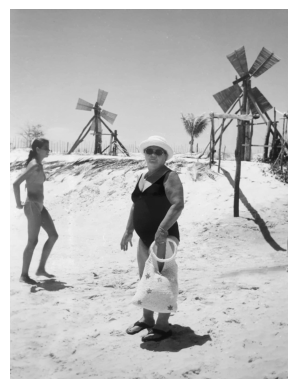

In [11]:
img = convert_to_grayscale(img)
plt.imshow(img, cmap = "gray")
plt.axis("off")

255


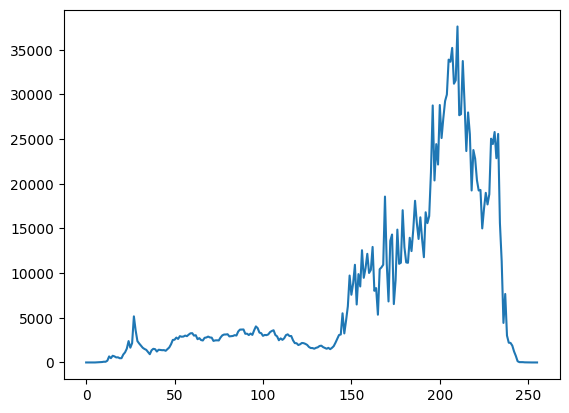

In [72]:
val, counts = histogram(img)

plt.plot(val, counts)

print(np.arange(0, 256, 1).astype(np.uint8)[255])


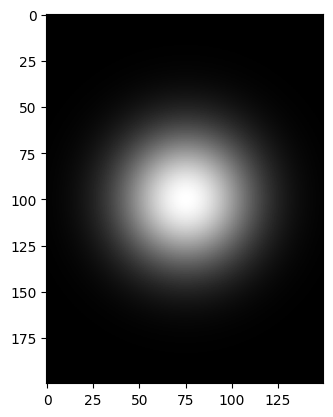

In [96]:
plt.imshow(gaussian((150, 200), 50.0), cmap = "gray")